In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import pandas as pd
import torch.optim as optim
from train_gp import *
import tqdm
import copy


In [2]:
small_dataset_path = 'data\DGA TC10.xlsx'

In [3]:
# Read the test data
small_dataset = pd.read_excel(small_dataset_path, sheet_name='Sheet1')
small_dataset = transform_small_dataset(small_dataset)
print(len(small_dataset))

343


In [4]:
import random

def sample_train_and_val_data(dataset:pd.DataFrame, 
                              sampled_data_per_class:int, 
                              random_state:int)->Dict[str,Tuple[np.ndarray,np.ndarray]]:
    # Set random seed for reproducibility
    _rng = random.Random(random_state)

    # Define class labels
    class_labels = ["D1", "D2", "PD", "T1", "T2", "T3"]

    # Get indices for each class label
    class_indices = {label: dataset.index[dataset["Justifikasi"] == label].tolist()
                    for label in class_labels}

    # Randomly sample 30 indices for each class
    selected_indices = {label: _rng.sample(indices, sampled_data_per_class)
                        for label, indices in class_indices.items()}

    # Combine all selected indices into a single list
    all_selected_indices = [idx for indices in selected_indices.values() for idx in indices]

    # Get all indices in the dataset
    all_indices = set(dataset.index)

    # Find indices that were not selected
    all_unselected_indices = list(all_indices.difference(all_selected_indices))

    # Extract features and labels
    train_dataset = dataset.loc[all_selected_indices]
    val_dataset = dataset.loc[all_unselected_indices]

    X_train = train_dataset.drop(columns="Justifikasi").to_numpy()
    y_train = train_dataset["Justifikasi"].map(encode_justifikasi).to_numpy()

    X_val = val_dataset.drop(columns="Justifikasi").to_numpy()
    y_val = val_dataset["Justifikasi"].map(encode_justifikasi).to_numpy()

    return {"train_data":(X_train,y_train),"val_data":(X_val,y_val)}


In [5]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.encoder = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(5, 64)),
            ('act1', nn.ReLU()),
            ('dense2', nn.Linear(64, 128)),
            ('act2', nn.ReLU()),
            ('output', nn.Linear(128, 256)),
            # ('output', nn.Linear(128, 6)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(256, 100)),
            ('act1', nn.ReLU()),
            ('dense2', nn.Linear(100, 50)),
            ('act2', nn.ReLU()),
            ('output', nn.Linear(50, 6)),
            ('outact', nn.Sigmoid()),
        ]))

    def forward(self, x):
        # x = torch.sigmoid(self.encoder(x))
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda:0 device


In [7]:
def calculate_accuracy(y_pred_prob, y):
    top_pred = y_pred_prob.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    print("Number of correct predictions", correct)
    acc = correct.float() / y.shape[0]
    return acc

# Sampled data for all classes = 30

In [8]:
X = small_dataset.drop(columns="Justifikasi").to_numpy()
y = small_dataset["Justifikasi"].map(encode_justifikasi).to_numpy()

sampled_data = sample_train_and_val_data(small_dataset,30,169)
X_train, y_train = sampled_data["train_data"]
X_val, y_val = sampled_data["val_data"]

In [9]:
X_tensor = torch.from_numpy(X).to(device, dtype=torch.float32)
print("X_tensor dtype: ",X_tensor.dtype)
print("X_tensor shape: ",X_tensor.shape)

y_tensor = torch.from_numpy(y).to(device)
print("y_tensor dtype: ",y_tensor.dtype)
print("y_tensor shape: ",y_tensor.shape)

X_train_tensor = torch.from_numpy(X_train).to(device, dtype=torch.float32)
print("X_train_tensor dtype: ",X_train_tensor.dtype)
print("X_train_tensor shape: ",X_train_tensor.shape)

y_train_tensor = torch.from_numpy(y_train).to(device)
print("y_train_tensor dtype: ",y_train_tensor.dtype)
print("y_train_tensor shape: ",y_train_tensor.shape)

X_val_tensor = torch.from_numpy(X_val).to(device, dtype=torch.float32)
print("X_val_tensor shape: ",X_val_tensor.shape)
print("X_val_tensor dtype: ",X_val_tensor.dtype)

y_val_tensor = torch.from_numpy(y_val).to(device)
print("y_val_tensor dtype: ",y_val_tensor.dtype)
print("y_val_tensor shape: ",y_val_tensor.shape)

X_tensor dtype:  torch.float32
X_tensor shape:  torch.Size([343, 5])
y_tensor dtype:  torch.int64
y_tensor shape:  torch.Size([343])
X_train_tensor dtype:  torch.float32
X_train_tensor shape:  torch.Size([180, 5])
y_train_tensor dtype:  torch.int64
y_train_tensor shape:  torch.Size([180])
X_val_tensor shape:  torch.Size([163, 5])
X_val_tensor dtype:  torch.float32
y_val_tensor dtype:  torch.int64
y_val_tensor shape:  torch.Size([163])


In [10]:
model = MLPClassifier()
model.to(device)

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_cross_entropy = np.inf   # init to infinity
best_weights = None
eval_history = []
train_history = []

In [11]:
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred_prob = model(X_batch)
            
            loss = loss_fn(y_pred_prob, y_batch)

            train_history.append(float(loss))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(loss=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred_prob = model(X_val_tensor)
    cross_entropy = loss_fn(y_pred_prob, y_val_tensor)
    cross_entropy = float(cross_entropy)
    eval_history.append(cross_entropy)
    # best_weights = copy.deepcopy(model.state_dict())
    if cross_entropy < best_cross_entropy:
        best_cross_entropy = cross_entropy
        best_weights = copy.deepcopy(model.state_dict())

Epoch 99: 100%|██████████| 18/18 [00:00<00:00, 166.36batch/s, loss=1.24]


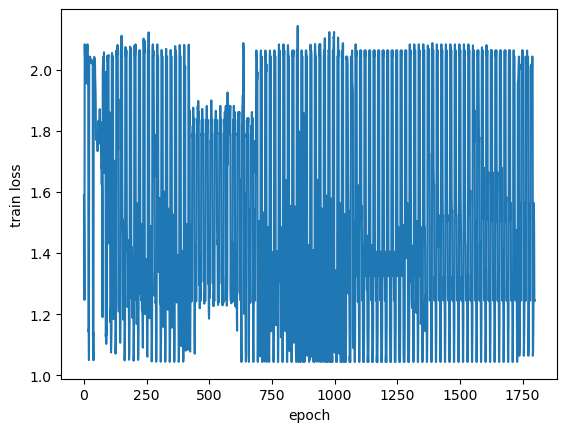

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_history)
plt.ylabel("train loss")
plt.xlabel("epoch")
plt.show()

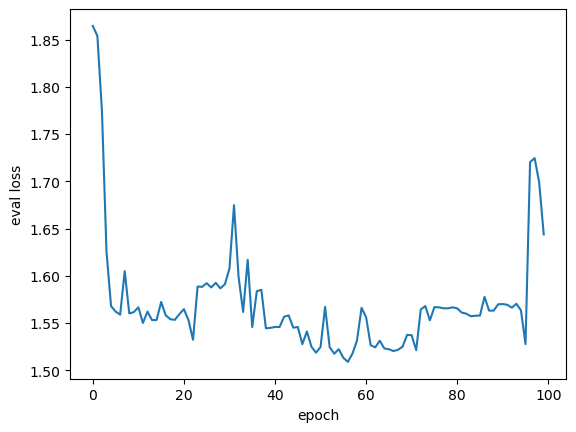

In [13]:
plt.plot(eval_history)
plt.ylabel("eval loss")
plt.xlabel("epoch")
plt.show()

In [14]:
model.load_state_dict(best_weights)

# Set to evaluation mode if you're going to evaluate or predict
model.eval()
# Now use model for evaluation or prediction
y_pred_prob_all = model(X_tensor)
accuracy = calculate_accuracy(y_pred_prob_all,y_tensor)
print(accuracy)


Number of correct predictions tensor(188, device='cuda:0')
tensor(0.5481, device='cuda:0')


# Sampled data for all classes = 20

In [15]:
X = small_dataset.drop(columns="Justifikasi").to_numpy()
y = small_dataset["Justifikasi"].map(encode_justifikasi).to_numpy()

sampled_data = sample_train_and_val_data(small_dataset,20,50)
X_train, y_train = sampled_data["train_data"]
X_val, y_val = sampled_data["val_data"]

In [16]:
X_tensor = torch.from_numpy(X).to(device, dtype=torch.float32)
print("X_tensor dtype: ",X_tensor.dtype)
print("X_tensor shape: ",X_tensor.shape)

y_tensor = torch.from_numpy(y).to(device)
print("y_tensor dtype: ",y_tensor.dtype)
print("y_tensor shape: ",y_tensor.shape)

X_train_tensor = torch.from_numpy(X_train).to(device, dtype=torch.float32)
print("X_train_tensor dtype: ",X_train_tensor.dtype)
print("X_train_tensor shape: ",X_train_tensor.shape)

y_train_tensor = torch.from_numpy(y_train).to(device)
print("y_train_tensor dtype: ",y_train_tensor.dtype)
print("y_train_tensor shape: ",y_train_tensor.shape)

X_val_tensor = torch.from_numpy(X_val).to(device, dtype=torch.float32)
print("X_val_tensor shape: ",X_val_tensor.shape)
print("X_val_tensor dtype: ",X_val_tensor.dtype)

y_val_tensor = torch.from_numpy(y_val).to(device)
print("y_val_tensor dtype: ",y_val_tensor.dtype)
print("y_val_tensor shape: ",y_val_tensor.shape)

X_tensor dtype:  torch.float32
X_tensor shape:  torch.Size([343, 5])
y_tensor dtype:  torch.int64
y_tensor shape:  torch.Size([343])
X_train_tensor dtype:  torch.float32
X_train_tensor shape:  torch.Size([120, 5])
y_train_tensor dtype:  torch.int64
y_train_tensor shape:  torch.Size([120])
X_val_tensor shape:  torch.Size([223, 5])
X_val_tensor dtype:  torch.float32
y_val_tensor dtype:  torch.int64
y_val_tensor shape:  torch.Size([223])


In [17]:
model = MLPClassifier()
model.to(device)

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_cross_entropy = np.inf   # init to infinity
best_weights = None
eval_history = []
train_history = []

In [18]:
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred_prob = model(X_batch)
            
            loss = loss_fn(y_pred_prob, y_batch)

            train_history.append(float(loss))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(loss=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred_prob = model(X_val_tensor)
    cross_entropy = loss_fn(y_pred_prob, y_val_tensor)
    cross_entropy = float(cross_entropy)
    eval_history.append(cross_entropy)
    # best_weights = copy.deepcopy(model.state_dict())
    if cross_entropy < best_cross_entropy:
        best_cross_entropy = cross_entropy
        best_weights = copy.deepcopy(model.state_dict())

Epoch 99: 100%|██████████| 12/12 [00:00<00:00, 160.65batch/s, loss=1.06]


In [19]:
model.load_state_dict(best_weights)

# Set to evaluation mode if you're going to evaluate or predict
model.eval()
# Now use model for evaluation or prediction
y_pred_prob_all = model(X_tensor)
accuracy = calculate_accuracy(y_pred_prob_all,y_tensor)
print(accuracy)


Number of correct predictions tensor(185, device='cuda:0')
tensor(0.5394, device='cuda:0')
